# Image Classification with MLP

- In this project we are going to classify Pokemon.
- Here we will use Neural Network for image classification

In [1]:
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
p=Path('./Dataset')
dirs=p.glob("*")

image_data=[]
labels=[]

label_dict={}
label_to_pokemon={}
counter=0
for i in dirs:
    label=str(i).split("\\")[-1]
    label_dict[label]=counter
    label_to_pokemon[counter]=label
    
    print(i)
    count=0
    
    for img_path in i.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(60,60))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(counter)
        count +=1
        
    print(count)
    counter +=1

Dataset\Bulbasaur
173
Dataset\Meowth
70
Dataset\Pikachu
199


### Visualize data

In [3]:
import numpy as np

In [4]:
X=np.array(image_data)
Y=np.array(labels)

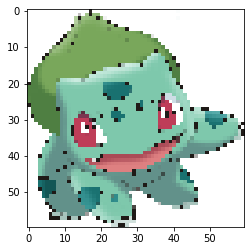

In [5]:
plt.imshow(X[0]/255)

In [6]:
def drawimage(image,label):
    plt.style.use('seaborn')
    plt.title(label_to_pokemon[label])
    plt.imshow(image)
    plt.show()

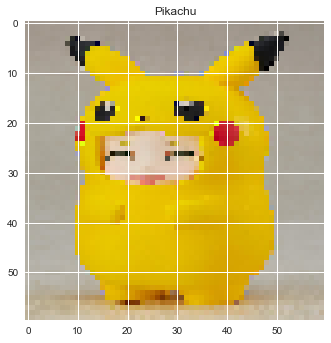

In [7]:
drawimage(X[344]/255,Y[344])

### Create train and test set

In [8]:
import random
random.seed(10)

In [9]:
#Shuffle our data
from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

#Normalisation
X = X/255.0

In [10]:
### Create Training and Testing Set
X_ = np.array(X)
Y_ = np.array(Y)

#Training Set
X = X_[:353,:]
Y = Y_[:353]

#Test Set
XTest = X_[353:,:]
YTest = Y_[353:]

print(X.shape,Y.shape)
print(XTest.shape,YTest.shape)

(353, 60, 60, 3) (353,)
(89, 60, 60, 3) (89,)


In [11]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {} #Dictionary
        
        #First Layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third Layer
        model['W3'] = np.random.randn(layers[1],layers[2])
        model['b3'] = np.zeros((1,layers[2]))
        
        #Output Layer
        model['W4'] = np.random.randn(layers[2],output_size)
        model['b4'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
    
    def forward(self,x):
        
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        b1, b2, b3,b4 = self.model['b1'],self.model['b2'],self.model['b3'],self.model['b4']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        a3 = np.tanh(z3)
        
        z4 = np.dot(a3,W4) + b4
        y_ = softmax(z4)
        
        self.activation_outputs = (a1,a2,a3,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        b1, b2, b3,b4 = self.model['b1'],self.model['b2'],self.model['b3'],self.model['b4']
        m = x.shape[0]
        
        a1,a2,a3,y_ = self.activation_outputs
        
        delta4 = y_ - y
        dw4 = np.dot(a3.T,delta4)
        db4 = np.sum(delta4,axis=0)
        
        delta3 = (1-np.square(a3))*np.dot(delta4,W4.T)
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        
        #Update the Model Parameters using Gradient Descent
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
        self.model["W4"]  -= learning_rate*dw4
        self.model['b4']  -= learning_rate*db4
        
        # :)
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3,W4 = self.model['W1'],self.model['W2'],self.model['W3'],self.model['W4']
        a1,a2,a3,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)

def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans        

In [12]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y,depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [13]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = 3
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        
        model.backward(X,Y_OHT,learning_rate)
        training_loss.append(l)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
            
    
    return training_loss

In [14]:
model = NeuralNetwork(input_size=10800,layers=[200,50,20],output_size=3)

In [15]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(353, 10800)
(89, 10800)


In [16]:
l = train(X,Y,model,1000,0.0005)

Epoch 0 Loss 1.1207
Epoch 50 Loss 0.2028
Epoch 100 Loss 0.1055
Epoch 150 Loss 0.1145
Epoch 200 Loss 0.1378
Epoch 250 Loss 0.1077
Epoch 300 Loss 0.1023
Epoch 350 Loss 0.0722
Epoch 400 Loss 0.0364
Epoch 450 Loss 0.0224
Epoch 500 Loss 0.0170
Epoch 550 Loss 0.0146
Epoch 600 Loss 0.0126
Epoch 650 Loss 0.0105
Epoch 700 Loss 0.0093
Epoch 750 Loss 0.0085
Epoch 800 Loss 0.0076
Epoch 850 Loss 0.0069
Epoch 900 Loss 0.0063
Epoch 950 Loss 0.0057


### Plot Loss vs Epochs

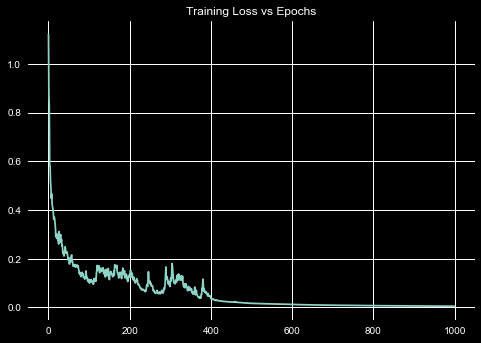

In [17]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.title("Training Loss vs Epochs")
plt.plot(l)

plt.show()

In [18]:
# Accuracy 
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Accuracy: %.4f  :)"%getAccuracy(X,Y,model))
print("Test Accuracy: %.4f :("%getAccuracy(XTest,YTest,model))

Train Accuracy: 1.0000  :)
Test Accuracy: 0.7416 :(


### Lets Test manually

In [ ]:
print('Enter the image path: ')
img_path=input()

img = image.load_img(img_path,target_size=(60,60))
img = image.img_to_array(img)
print(img.shape)
img= img.reshape(1,-1)

y=model.predict(img)
for i in label_to_pokemon.keys():
    print(i)
    if i==y:
        print(label_to_pokemon[i])
        break

### Plot confusion matrix

A <b>confusion matrix</b> is a matrix (table) that can be used to measure the performance of an machine learning algorithm, usually a supervised learning one. Each row of the confusion matrix represents the instances of an actual class and each column represents the instances of a predicted class.

In [19]:
from sklearn.metrics import confusion_matrix
from visualize import plot_confusion_matrix
from sklearn.metrics import classification_report

In [20]:
output=model.predict(XTest)
conf_mat=confusion_matrix(output,YTest)
print(conf_mat)

[[31  3  3]
 [ 3  4  4]
 [ 7  3 31]]


In [21]:
print(classification_report(output,YTest))

              precision    recall  f1-score   support

           0       0.76      0.84      0.79        37
           1       0.40      0.36      0.38        11
           2       0.82      0.76      0.78        41

    accuracy                           0.74        89
   macro avg       0.66      0.65      0.65        89
weighted avg       0.74      0.74      0.74        89



Confusion matrix, without normalization
[[31  3  3]
 [ 3  4  4]
 [ 7  3 31]]


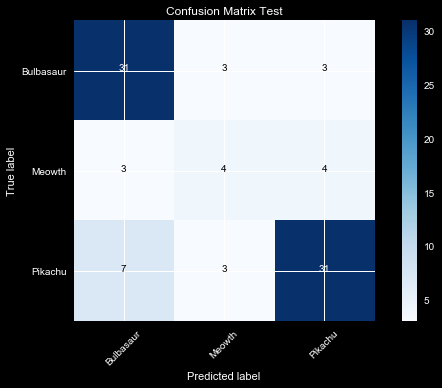

In [22]:
plot_confusion_matrix(conf_mat,classes=["Bulbasaur","Meowth","Pikachu"],title="Confusion Matrix Test")